# Analyzing Cities: A Case Study of Singapore with comparisons between Singapore and New York   
### Final Project: Data Science Professional Certificate by IBM
__Michael W.D. Kurz__

## Table of Contents    
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

As cities’ around the world grow larger it becomes increasingly important to understand their internal structure as well as the similarities and differences between cities. The analysis is intended as a case study focusing on two major cities: Singapore and New York City.   
    
First, focusing on Singapore I am using unsupervised machine learning techniques to identify clusters of similar neighborhoods within and across the five regions of Singapore (Central, North, North-East, East, and West). For this analysis I am defining similarity in terms of the types and number of amenities in the neighborhood. Thus, I describe each neighborhood as a vector of the amenities within the neighborhood. I augment this by demographic data on the residents of each neighborhood to gain a better understanding of which demographic groups reside most commonly in which kind of neighborhood. I will investigate whether similarity in terms of amenities correlates with similarity in terms of the demographic characteristics of residents.    
    
Identifying neighborhoods that are similar to each other in terms of amenities and terms demographic groups helps urban planners/city planners to make more informed decisions regarding zoning and the branding of areas of a city towards tourists and businesses. It may also help the proprietors of restaurants, bars, etc. to make informed decisions about the location of new venues. Additionally, the results can help residents that need to relocate from one part of the city to another to find neighborhoods with similar amenities.    
    
Next, I create a similar dataset of amenities within neighborhoods in New York City and identify similar neighborhoods within and across boroughs of New York City. This part of the analysis mirrors the analysis of Singapore but excludes demographic data. New York City and Singapore are both highly urbanized, densely populated areas with vastly diverse populations and both cities are regarded as financial and economic hubs. While comparisons such as the one in this analysis have been done in academic literature within countries, not much work has been done regarding comparisons cities across countries.     
    
Based on the neighborhood amenities data in New York and Singapore I will examine similarities across the two cities. This sort of across city comparisons can help, for example, expatriates or business travelers who move move to or travel to one of the cities identify neighborhoods that are similar to the one they currently live in. Since Singapore is located in South-East Asia and New York City in the USA, expatriates or business travelers who never have been to their destination city may find such analysis useful.

## Data <a name="data"></a>

___Neighborhood data New York City:___  
* Dataset
    
___Neighborhood data and demographic data Singapore:___
* neighborhoods
* demographic data
     
___Amenities data:___
* Foursquare API

### Data Collection and preparation

#### Neighborhoods in Singapore

In [1]:
import pandas as pd # use dataframes in Pyhton, read .csv-files etc.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import geopandas as gpd # use shapefiles
from pyproj import Proj, transform # change map projection
import folium # Libarary that contains a detailed world map and the ability to zoom in down to the city level
from geopy.geocoders import Nominatim # reverse geocoder API to get coordinates for addresses/cites, etc.

import json
import requests

import matplotlib.pyplot as plt

I use a shapefile of Singapore that contains the boundaries of a sub-zones. The shapefile is available under an open data license [from a website of the government of Singapore](https://geo.data.gov.sg/mp14-subzone-web-pl/2014/12/05/shp/mp14-subzone-web-pl.zip).     
The government of Singapore defines sub-zones as follows: _'Subzones are divisions within a planning area which are usually centred around a focal point such as neighbourhood centre or activity node.'_    

I use the file 'Master Plan 2014 Subzone Boundary (Web)'. The master plan is a medium term development plan for a period of 10-15 years.

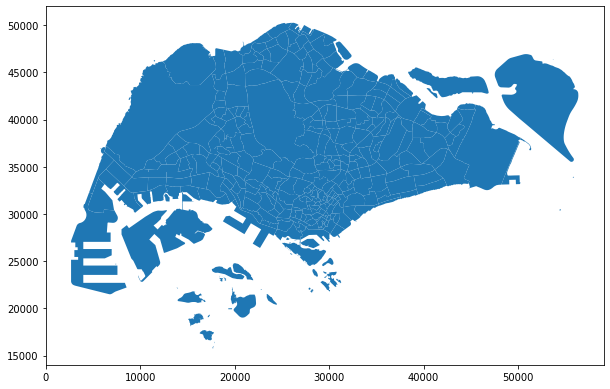

In [3]:
pathSing_shape = r'C:\Users\michael.kurz\Documents\Git_projects\Singapore_Urban_Form\Data\master-plan-2014-subzone-boundary-web-shp\MP14_SUBZONE_WEB_PL.shp'
singaporeShape = gpd.read_file(pathSing_shape)
ax = singaporeShape.plot(figsize=(10,7))
plt.show()

Coordinates in the shapefile are not longitude and latitude. Since I will be needing longitude and latitude coordiantes later on to get data from Foursquare, I will have to change to transform the coordinates. To do so, I need to get the projection of the map defined by the shapefile first:

In [4]:
singaporeShape.crs

{'proj': 'tmerc',
 'lat_0': 1.366666666666667,
 'lon_0': 103.8333333333333,
 'k': 1,
 'x_0': 28001.642,
 'y_0': 38744.572,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

The information in crs tells use how the map of Singapore is projected. In this case a transverse mercator projection (tmerc) centered on 1.367°E 103.83°N (lat_0, lon_0). x_0,y_0 are the corresponding x,y coordinates of the center point of the map. Units in the map are meters. I can now extract the x,y coordinates of the geometric center point of each neighborhood polygon (its centroid) from the shapefile and use the information about way the map in the shapefiel is projected to convert the the x,y coordinates of each point to longitude and latitude coordinates.

In [5]:
singaporeDf = pd.DataFrame(columns=['SubZone_Code', 'SubZone_Name','Region_Code', 'Region_Name', 'SubZoneArea', 'latitude', 'longitude', 'x', 'y']) 

projection_string = "+proj=tmerc +lat_0=1.366666666666667 +lon_0=103.8333333333333 +k=1 +x_0=28001.642 +y_0=38744.572 +datum=WGS84 +units=m +no_defs"
p = Proj(projection_string)

for index,row in singapore.iterrows():
    lng, lat = p(row.geometry.centroid.x,row.geometry.centroid.y, inverse=True)
    singaporeDf.loc[index] = [row.SUBZONE_C, row.SUBZONE_N.lower(), row.REGION_C, row.REGION_N, row.geometry.area/10**6, lat, lng, row.geometry.centroid.x,row.geometry.centroid.y]

singaporeDf.head()

,SubZone_Code,SubZone_Name,Region_Code,Region_Name,SubZoneArea,latitude,longitude,x,y
0,MSSZ01,marina south,CR,CENTRAL REGION,1.630379,1.280531,103.865629,31595.835746,29220.187377
1,OTSZ01,pearl's hill,CR,CENTRAL REGION,0.559816,1.285613,103.839420,28679.063482,29782.051966
2,SRSZ03,boat quay,CR,CENTRAL REGION,0.160807,1.287355,103.848189,29654.959448,29974.655356
3,BMSZ08,henderson hill,CR,CENTRAL REGION,0.595429,1.286985,103.822382,26782.826115,29933.765194
4,BMSZ03,redhill,CR,CENTRAL REGION,0.387429,1.287635,103.817162,26201.958019,30005.703511


The above dataframe now contains for each neighborhood (subzone): the region it belongs to, its area in sq-km, latitude and longitude coordinates, and x,y coordinates. I will use the latitude and longitude coordinates primarily to obtain the venues data from Foursquare. The area in sq-km can be used to inform the choice of a reasonable radius for the search query in Foursquare as the neighborhoods seem to vary in size.

In [6]:
singaporeDf.loc[:,'SubZone_Code':'SubZoneArea'].groupby('Region_Name').describe()

SubZoneArea                                          \
                        count      mean       std       min       25%   
Region_Name                                                             
CENTRAL REGION          134.0  1.017952  1.078615  0.039438  0.337352   
EAST REGION              30.0  3.765656  6.179367  0.494504  1.529476   
NORTH REGION             41.0  3.400137  6.138037  0.143138  1.281297   
NORTH-EAST REGION        48.0  2.834449  9.526342  0.316882  0.947999   
WEST REGION              70.0  3.673004  9.612790  0.380202  0.914210   

                                                  
                        50%       75%        max  
Region_Name                                       
CENTRAL REGION     0.593604  1.347130   7.601894  
EAST REGION        2.383305  3.407323  35.096029  
NORTH REGION       1.648630  2.553464  37.147854  
NORTH-EAST REGION  1.331205  1.757305  67.250563  
WEST REGION        1.504424  2.463417  69.748299

Most neighborhoods are located in the central region (134 neighborhoods), the second most on west region (70 neighborhoods). There is a lot variation in neighborhood sizes. The average area of a neighborhood ranges approximately 1 sq-km (central region) to almost 3.8 sq-km (east region). Within each regon on the variation in the size of subzone areas is large.

Before continuing I will first attempt to plot the neighborhood locations on a folium map.

In [7]:
# Since I'll be needing this again later on, I collect the code in a function
def GetCityCoords(address, agent):
    geolocator = Nominatim(user_agent = agent)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return([latitude, longitude])

In [8]:
singapore_coords = GetCityCoords('Singapore', 'Singapore_App')
print('The geographical cooridnates of Singapore are Latitude: {}, Longitude: {}.'.format(singapore_coords[0],singapore_coords[1]))

The geographical cooridnates of Singapore are Latitude: 1.357107, Longitude: 103.8194992.


In [10]:
# To render the folium map I use the default OpenStreetMaps tile
mySingapore_map = folium.Map(location=singapore_coords, zoom_start=11, control_scale=True) 

for lat, lng, subzone, region in zip(singaporeDf['latitude'], singaporeDf['longitude'], singaporeDf['SubZone_Name'], singaporeDf['Region_Name']):
    label = '{}, {}'.format(subzone, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(mySingapore_map)

# Render interactive map including neighborhood locations:
mySingapore_map

For each sub-zone I want to get some demographic data on the sub-zone's residents. Specifically, I want to get the following information for each sub-zone: number of residents, age structure of residents, most common types of dwelling, ethnicity.

In [18]:
pathDataFile = r'C:\Users\michael.kurz\Documents\Git_projects\Singapore_Urban_Form\Data\Demographic_Data.xlsx'
hhDF = pd.read_excel(pathDataFile)
hhDF.SubZone_Name = hhDF.SubZone_Name.str.lower()
hhDF.head()

,SubZone_Name,Resident_Population,Age_0-4,Age_5-9,Age_10-14,Age_15-19,Age_20-24,Age_25-29,Age_30-34,Age_35-39,Age_40-44,Age_45-49,Age_50-54,Age_55-59,Age_60-64,Age_65-69,Age_70-74,Age_75-79,Age_80-84,Age_85 & Over,HDB_1-2_Room,HDB_3-Room,HDB_4-Room,HDB_5-Room_Exec,Condo_Other,Landed_Properties,Other_dwelling,Chinese,Malaya,Indians,Other_ethnicity
0,ang mo kio town centre,5020,260,280,320,280,260,310,370,420,490,420,350,320,280,270,160,120,60,50,3250,0,460,730,2060,1730,0,4260,210,360,190
1,cheng san,29770,1290,1180,1290,1400,1570,1830,2490,2490,2460,2220,2320,2290,2320,1920,1070,790,480,370,29610,840,14740,8690,5350,0,0,24660,2140,2380,600
2,chong boon,27900,910,1100,1180,1370,1520,1800,1980,2100,2040,2060,2270,2260,2250,1950,1290,920,540,380,27670,1840,13500,8810,3520,0,0,22910,1950,2400,630
3,kebun bahru,23910,780,1010,1080,1240,1380,1490,1570,1730,1860,1860,1940,1890,1800,1610,1010,810,530,330,22460,1920,11750,6460,2320,0,1170,19210,2200,1910,590
4,sembawang hills,6890,200,360,460,550,550,450,310,320,500,550,590,520,430,400,260,190,140,130,0,0,0,0,0,160,6660,6080,100,500,220


In [20]:
singapore_popDf = pd.DataFrame()

singapore_popDf['SubZone_Name'] = hhDF['SubZone_Name']

singapore_popDf['Resident_Population'] = hhDF['Resident_Population']

singapore_popDf['Age_(0-19)'] = (hhDF['Age_0-4'] + hhDF['Age_5-9'] + hhDF['Age_10-14'] + hhDF['Age_15-19'])/hhDF['Resident_Population']
singapore_popDf['Age_(20-34)'] = (hhDF['Age_20-24'] + hhDF['Age_25-29'] + hhDF['Age_30-34'])/hhDF['Resident_Population']
singapore_popDf['Age_(35-49)'] = (hhDF['Age_35-39'] + hhDF['Age_40-44'] + hhDF['Age_45-49'])/hhDF['Resident_Population']
singapore_popDf['Age_(50-64)'] = (hhDF['Age_50-54'] + hhDF['Age_55-59'] + hhDF['Age_60-64'])/hhDF['Resident_Population']
singapore_popDf['Age_(65-)'] = (hhDF['Age_65-69'] + hhDF['Age_70-74'] + hhDF['Age_75-79'] + hhDF['Age_80-84'] + hhDF['Age_85 & Over'])/hhDF['Resident_Population']

singapore_popDf['HDB_1-2_rooms'] = hhDF['HDB_1-2_Room']/hhDF['Resident_Population']
singapore_popDf['HDB_3_rooms'] = hhDF['HDB_3-Room']/hhDF['Resident_Population']
singapore_popDf['HDB_4_rooms'] = hhDF['HDB_4-Room']/hhDF['Resident_Population']
singapore_popDf['HDB_5_rooms'] = hhDF['HDB_5-Room_Exec']/hhDF['Resident_Population']
singapore_popDf['Condos'] = hhDF['Condo_Other']/hhDF['Resident_Population']
singapore_popDf['Other_dwelling'] = (hhDF['Landed_Properties'] + hhDF['Other_dwelling'])/hhDF['Resident_Population']

singapore_popDf['Chinese'] = hhDF['Chinese']/hhDF['Resident_Population']
singapore_popDf['Malaya'] = hhDF['Malaya']/hhDF['Resident_Population']
singapore_popDf['Indian'] = hhDF['Indians']/hhDF['Resident_Population']
singapore_popDf['Other_Ethnicity'] = hhDF['Other_ethnicity']/hhDF['Resident_Population']

singapore_popDf.fillna(0, inplace=True)

singapore_popDf = singapore_popDf.merge(singaporeDf, how='inner', on='SubZone_Name')
singapore_popDf.head()

,SubZone_Name,Resident_Population,Age_(0-19),Age_(20-34),Age_(35-49),Age_(50-64),Age_(65-),HDB_1-2_rooms,HDB_3_rooms,HDB_4_rooms,HDB_5_rooms,Condos,Other_dwelling,Chinese,Malaya,Indian,Other_Ethnicity,SubZone_Code,Region_Code,Region_Name,SubZoneArea,latitude,longitude,x,y
0,ang mo kio town centre,5020,0.227092,0.187251,0.264940,0.189243,0.131474,0.647410,0.000000,0.091633,0.145418,0.410359,0.344622,0.848606,0.041833,0.071713,0.037849,AMSZ01,NER,NORTH-EAST REGION,0.316882,1.372770,103.846813,29501.765925,39419.404931
1,cheng san,29770,0.173329,0.197850,0.240846,0.232785,0.155526,0.994625,0.028216,0.495129,0.291905,0.179711,0.000000,0.828351,0.071884,0.079946,0.020155,AMSZ02,NER,NORTH-EAST REGION,0.955710,1.372715,103.854095,30312.192396,39413.347824
2,chong boon,27900,0.163441,0.189964,0.222222,0.243011,0.182079,0.991756,0.065950,0.483871,0.315771,0.126165,0.000000,0.821147,0.069892,0.086022,0.022581,AMSZ03,NER,NORTH-EAST REGION,1.078622,1.364265,103.855653,30485.510968,38478.993077
3,kebun bahru,23910,0.171895,0.185696,0.227938,0.235466,0.179423,0.939356,0.080301,0.491426,0.270180,0.097031,0.048934,0.803430,0.092012,0.079883,0.024676,AMSZ06,NER,NORTH-EAST REGION,1.046417,1.373467,103.839610,28700.167402,39496.506105
4,sembawang hills,6890,0.227866,0.190131,0.198839,0.223512,0.162554,0.000000,0.000000,0.000000,0.000000,0.000000,0.989840,0.882438,0.014514,0.072569,0.031930,AMSZ07,NER,NORTH-EAST REGION,0.894516,1.374715,103.830766,27715.923623,39634.529022


In [23]:
singapore_popDf.loc[:,'Resident_Population':'SubZoneArea'].groupby('Region_Name').describe()

Resident_Population                                          \
                                count          mean           std  min    25%   
Region_Name                                                                     
CENTRAL REGION                  134.0   7014.701493   8922.988532  0.0  240.0   
EAST REGION                      30.0  23114.666667  33120.380821  0.0   20.0   
NORTH REGION                     41.0  12972.682927  21266.907512  0.0   20.0   
NORTH-EAST REGION                48.0  17386.458333  16992.515435  0.0   52.5   
WEST REGION                      70.0  12900.000000  16560.591164  0.0   10.0   

                                              Age_(0-19)                      \
                       50%      75%       max      count      mean       std   
Region_Name                                                                    
CENTRAL REGION      3230.0  10917.5   41710.0      134.0  0.157641  0.081560   
EAST REGION         4955.0  37912.5  138500.0       30.0  0.148782  0.113344   
NORTH REGION         900.0  26860.0   95510.0       41.0  0.125343  0.121221   
NORTH-EAST REGION  15120.0  28010.0   59860.0       48.0  0.163213  0.107007   
WEST REGION         5640.0  21267.5   70890.0       70.0  0.126585  0.113019   

                                                               Age_(20-34)  \
                   min       25%       50%       75%       max       count   
Region_Name                                                                  
CENTRAL REGION     0.0  0.134394  0.179103  0.213203  0.312500       134.0   
EAST REGION        0.0  0.000000  0.193221  0.224448  0.373563        30.0   
NORTH REGION       0.0  0.000000  0.181818  0.250000  0.310105        41.0   
NORTH-EAST REGION  0.0  0.000000  0.195901  0.230116  0.303112        48.0   
WEST REGION        0.0  0.000000  0.189655  0.232981  0.279907        70.0   

                                                                          \
                       mean       std  min       25%       50%       75%   
Region_Name                                                                
CENTRAL REGION     0.155683  0.086082  0.0  0.153846  0.174978  0.190078   
EAST REGION        0.134341  0.099193  0.0  0.000000  0.180557  0.212891   
NORTH REGION       0.118867  0.113609  0.0  0.000000  0.170163  0.219768   
NORTH-EAST REGION  0.153663  0.101658  0.0  0.000000  0.195912  0.217320   
WEST REGION        0.124041  0.109375  0.0  0.000000  0.189336  0.222878   

                            Age_(35-49)                                     \
                        max       count      mean       std  min       25%   
Region_Name                                                                  
CENTRAL REGION     0.694444       134.0  0.217677  0.110853  0.0  0.208346   
EAST REGION        0.237466        30.0  0.161283  0.117605  0.0  0.000000   
NORTH REGION       0.274781        41.0  0.128613  0.119627  0.0  0.000000   
NORTH-EAST REGION  0.308525        48.0  0.171985  0.110231  0.0  0.000000   
WEST REGION        0.277778        70.0  0.136094  0.119774  0.0  0.000000   

                                                Age_(50-64)            \
                        50%       75%       max       count      mean   
Region_Name                                                             
CENTRAL REGION     0.239711  0.270233  0.454545       134.0  0.181257   
EAST REGION        0.210577  0.231687  0.327586        30.0  0.151848   
NORTH REGION       0.193299  0.237398  0.281087        41.0  0.116172   
NORTH-EAST REGION  0.212117  0.241574  0.346154        48.0  0.156376   
WEST REGION        0.220992  0.235354  0.297329        70.0  0.125592   

                                                                          \
                        std  min       25%       50%       75%       max   
Region_Name                                                                
CENTRAL REGION     0.086832  0.0  0.176549  0.210331  0.

In [24]:
with open(r'C:\Users\michael.kurz\Documents\Git_projects\Foursquare_Credentials.json') as f:
    data = json.load(f)
    fSqure_credentials = {'CLIENT_ID':data['CLIENT_ID'],'CLIENT_SECRET':data['CLIENT_SECRET'],'VERSION':data['VERSION']}

In [ ]:
venues_list = []
myLimit = 100 # this is the max allowed by the Foursquare API

# I use a different search radius depending on the region of Singapore.
radiusDict = {'CENTRAL REGION': 600, 'EAST REGION': 2000, 'NORTH REGION': 1500 , 'NORTH-EAST REGION': 1500, 'WEST REGION': 2000}

# loop through all post code areas in the dataset and get Foursquare data for each post code area
for subzoneCode, region, subzoneName, lat, lng in zip(singaporeDf['SubZone_Code'], singaporeDf['Region_Name'], singaporeDf['SubZone_Name'], singaporeDf['latitude'], singaporeDf['longitude']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    fSqure_credentials['CLIENT_ID'],
    fSqure_credentials['CLIENT_SECRET'],
    fSqure_credentials['VERSION'],
    lat,
    lng,
    radiusDict[region],
    myLimit)
    results = requests.get(url).json()
    loc_venue = results['response']['groups'][0]['items']
    venues_list.append([(subzoneCode,region, lat, lng, subzoneName, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],v['venue']['categories'][0]['name']) for v in loc_venue])

singapore_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
singapore_venues.columns = ['SubZone_Code', 'Region_Name', 
                  'latitude', 
                  'longitude',
                  'SubZone_Name',
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']

singapore_venues.head()

In [ ]:
print('The dataframe has {} rows and {} columns.'.format(singapore_venues.shape[0],singapore_venues.shape[1]))
print('There are {} unique venue categories and {} unique venues in the dataframe.'.format(len(singapore_venues['Venue_Category'].unique()),len(singapore_venues['Venue'].unique())))

In [ ]:
venue_counts = singapore_venues.groupby('SubZone_Name').count()
venue_counts['Venue Category']

In [ ]:
singapore_onehot = pd.get_dummies(singapore_venues[['Venue_Category']], prefix='', prefix_sep='')
singapore_onehot['SubZone_Name'] = singapore_venues['SubZone_Name']


singapore_columns = [singapore_onehot.columns[-1]] + list(singapore_onehot.columns[:-1])
singapore_onehot = singapore_onehot[fixed_columns]
singapore_onehot.head()

In [ ]:
singapore_onehot.shape

In [ ]:
singapore_grouped = singapore_onehot.groupby('SubZone_Name').mean().reset_index()
singapore_grouped.head()

In [ ]:
num_top_venues = 10

# create columns according to number of top venues
columns = ['SubZone_Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postcode_venues_sorted = pd.DataFrame(columns=columns)

postcode_venues_sorted['SubZone_Name'] = singapore_grouped['SubZone_Name']

for ind in np.arange(singapore_grouped.shape[0]):
    postcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(singapore_grouped.iloc[ind, :], num_top_venues)

postcode_venues_sorted.head()

#### Neighborhoods in New York City

In [11]:
with open(r'C:\Users\michael.kurz\Documents\Git_projects\Singapore_Urban_Form\Data\nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [12]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [13]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [15]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [16]:
nyc_coords = GetCityCoords('New York City, NY', 'Singapore_App')
print('The geograpical coordinate of New York City are {}, {}.'.format(nyc_coords[0],nyc_coords[1]))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [17]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=nyc_coords, zoom_start=10, control_scale=True)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork